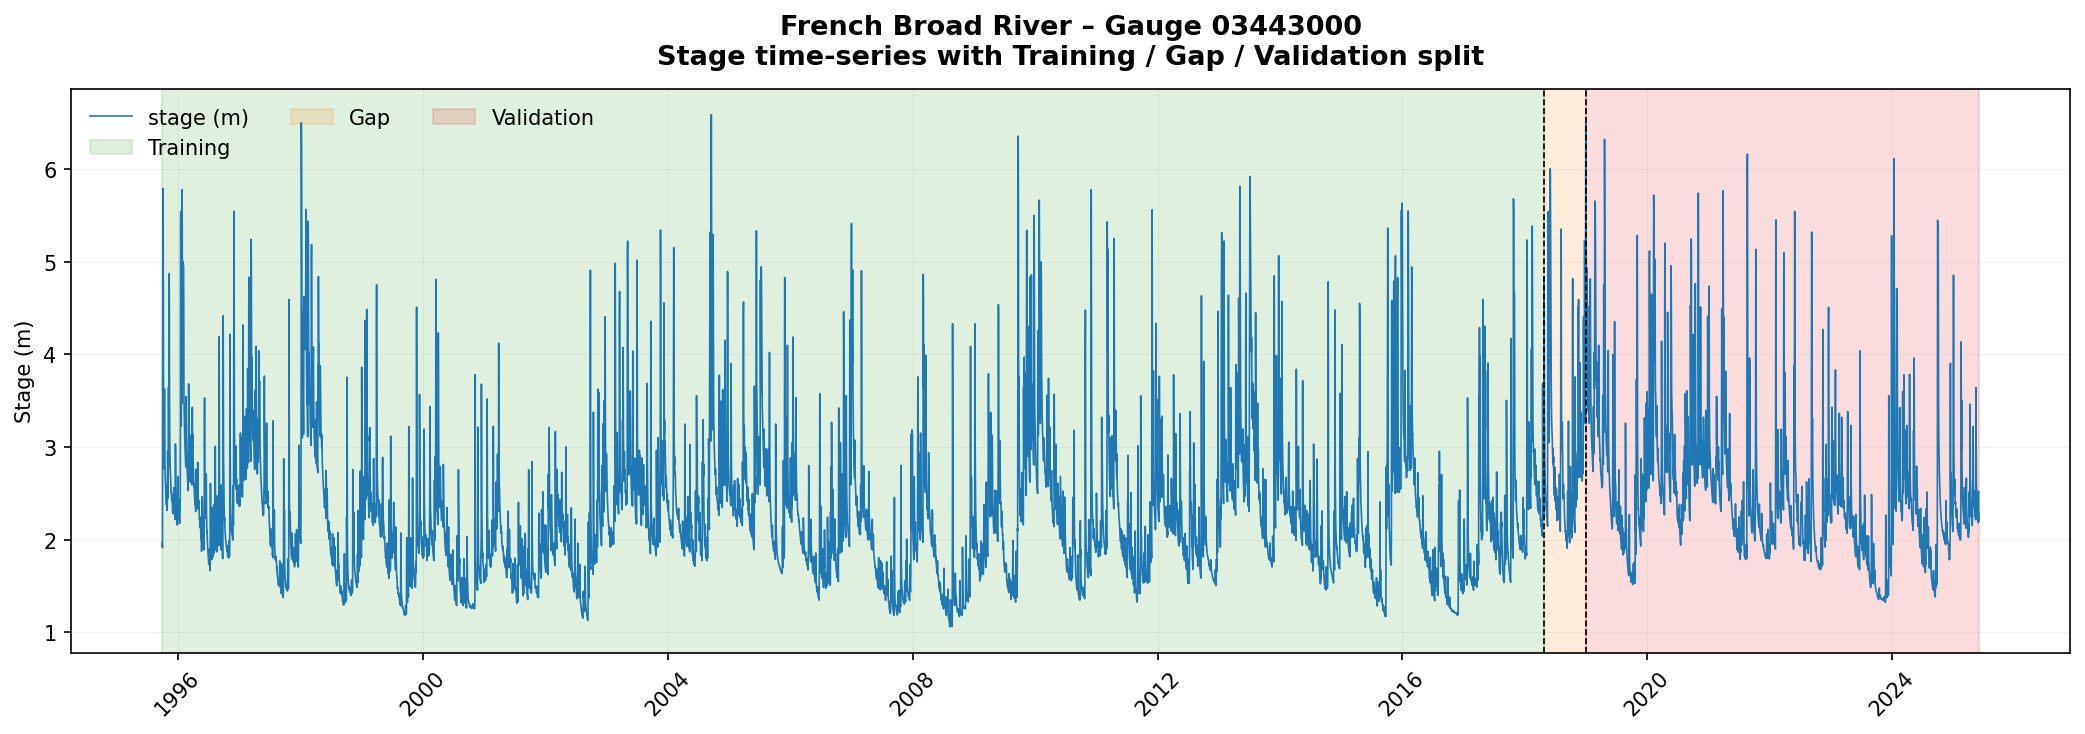

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# ---- 1. read & prepare ------------------------------------------------------
df = pd.read_csv("data/combined_dataset.csv", parse_dates=["datetime"])
df.set_index("datetime", inplace=True)

# date cut-offs you already used in the notebooks
train_end = pd.Timestamp("2018-04-21")
gap_start = pd.Timestamp("2018-04-22")      # the day after train_end
val_start = pd.Timestamp("2019-01-01")

# ---- 2. plot ----------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14,5), dpi=150)

ax.plot(df.index, df["stage_m"], lw=0.8, color="#1f78b4", label="stage (m)")

# colour-coded periods  (alpha ≈ 0.15 looks nice in print)
ax.axvspan(df.index.min(), train_end,           color="#33a02c", alpha=0.15,
           label="Training")
ax.axvspan(gap_start,       val_start-pd.Timedelta(days=1),
           color="#ff7f00", alpha=0.15, label="Gap")
ax.axvspan(val_start,       df.index.max(),     color="#e31a1c", alpha=0.15,
           label="Validation")

# vertical guide lines (optional but helps the eye)
for d in [train_end, val_start]:
    ax.axvline(d, color="k", ls="--", lw=0.8)

# ---- 3. cosmetics -----------------------------------------------------------
ax.set_title("French Broad River – Gauge 03443000\nStage time-series with Training / Gap / Validation split",
             fontsize=13, weight="bold", pad=12)
ax.set_ylabel("Stage (m)")

ax.legend(frameon=False, ncol=3, loc="upper left")

# compact x-axis
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.xticks(rotation=45)

ax.grid(alpha=0.3, lw=0.3)
plt.tight_layout()
plt.show()

# ---- 4. export for thesis --------------------------------------------------
# Uncomment the line below to save the figure as a high-resolution PNG
# fig.savefig("fig_02_timeseries_split.png", dpi=300, bbox_inches="tight")


2025-06-20 15:59:20.902415: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-20 15:59:21.068166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750424361.151868  266118 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750424361.180671  266118 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750424361.347045  266118 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

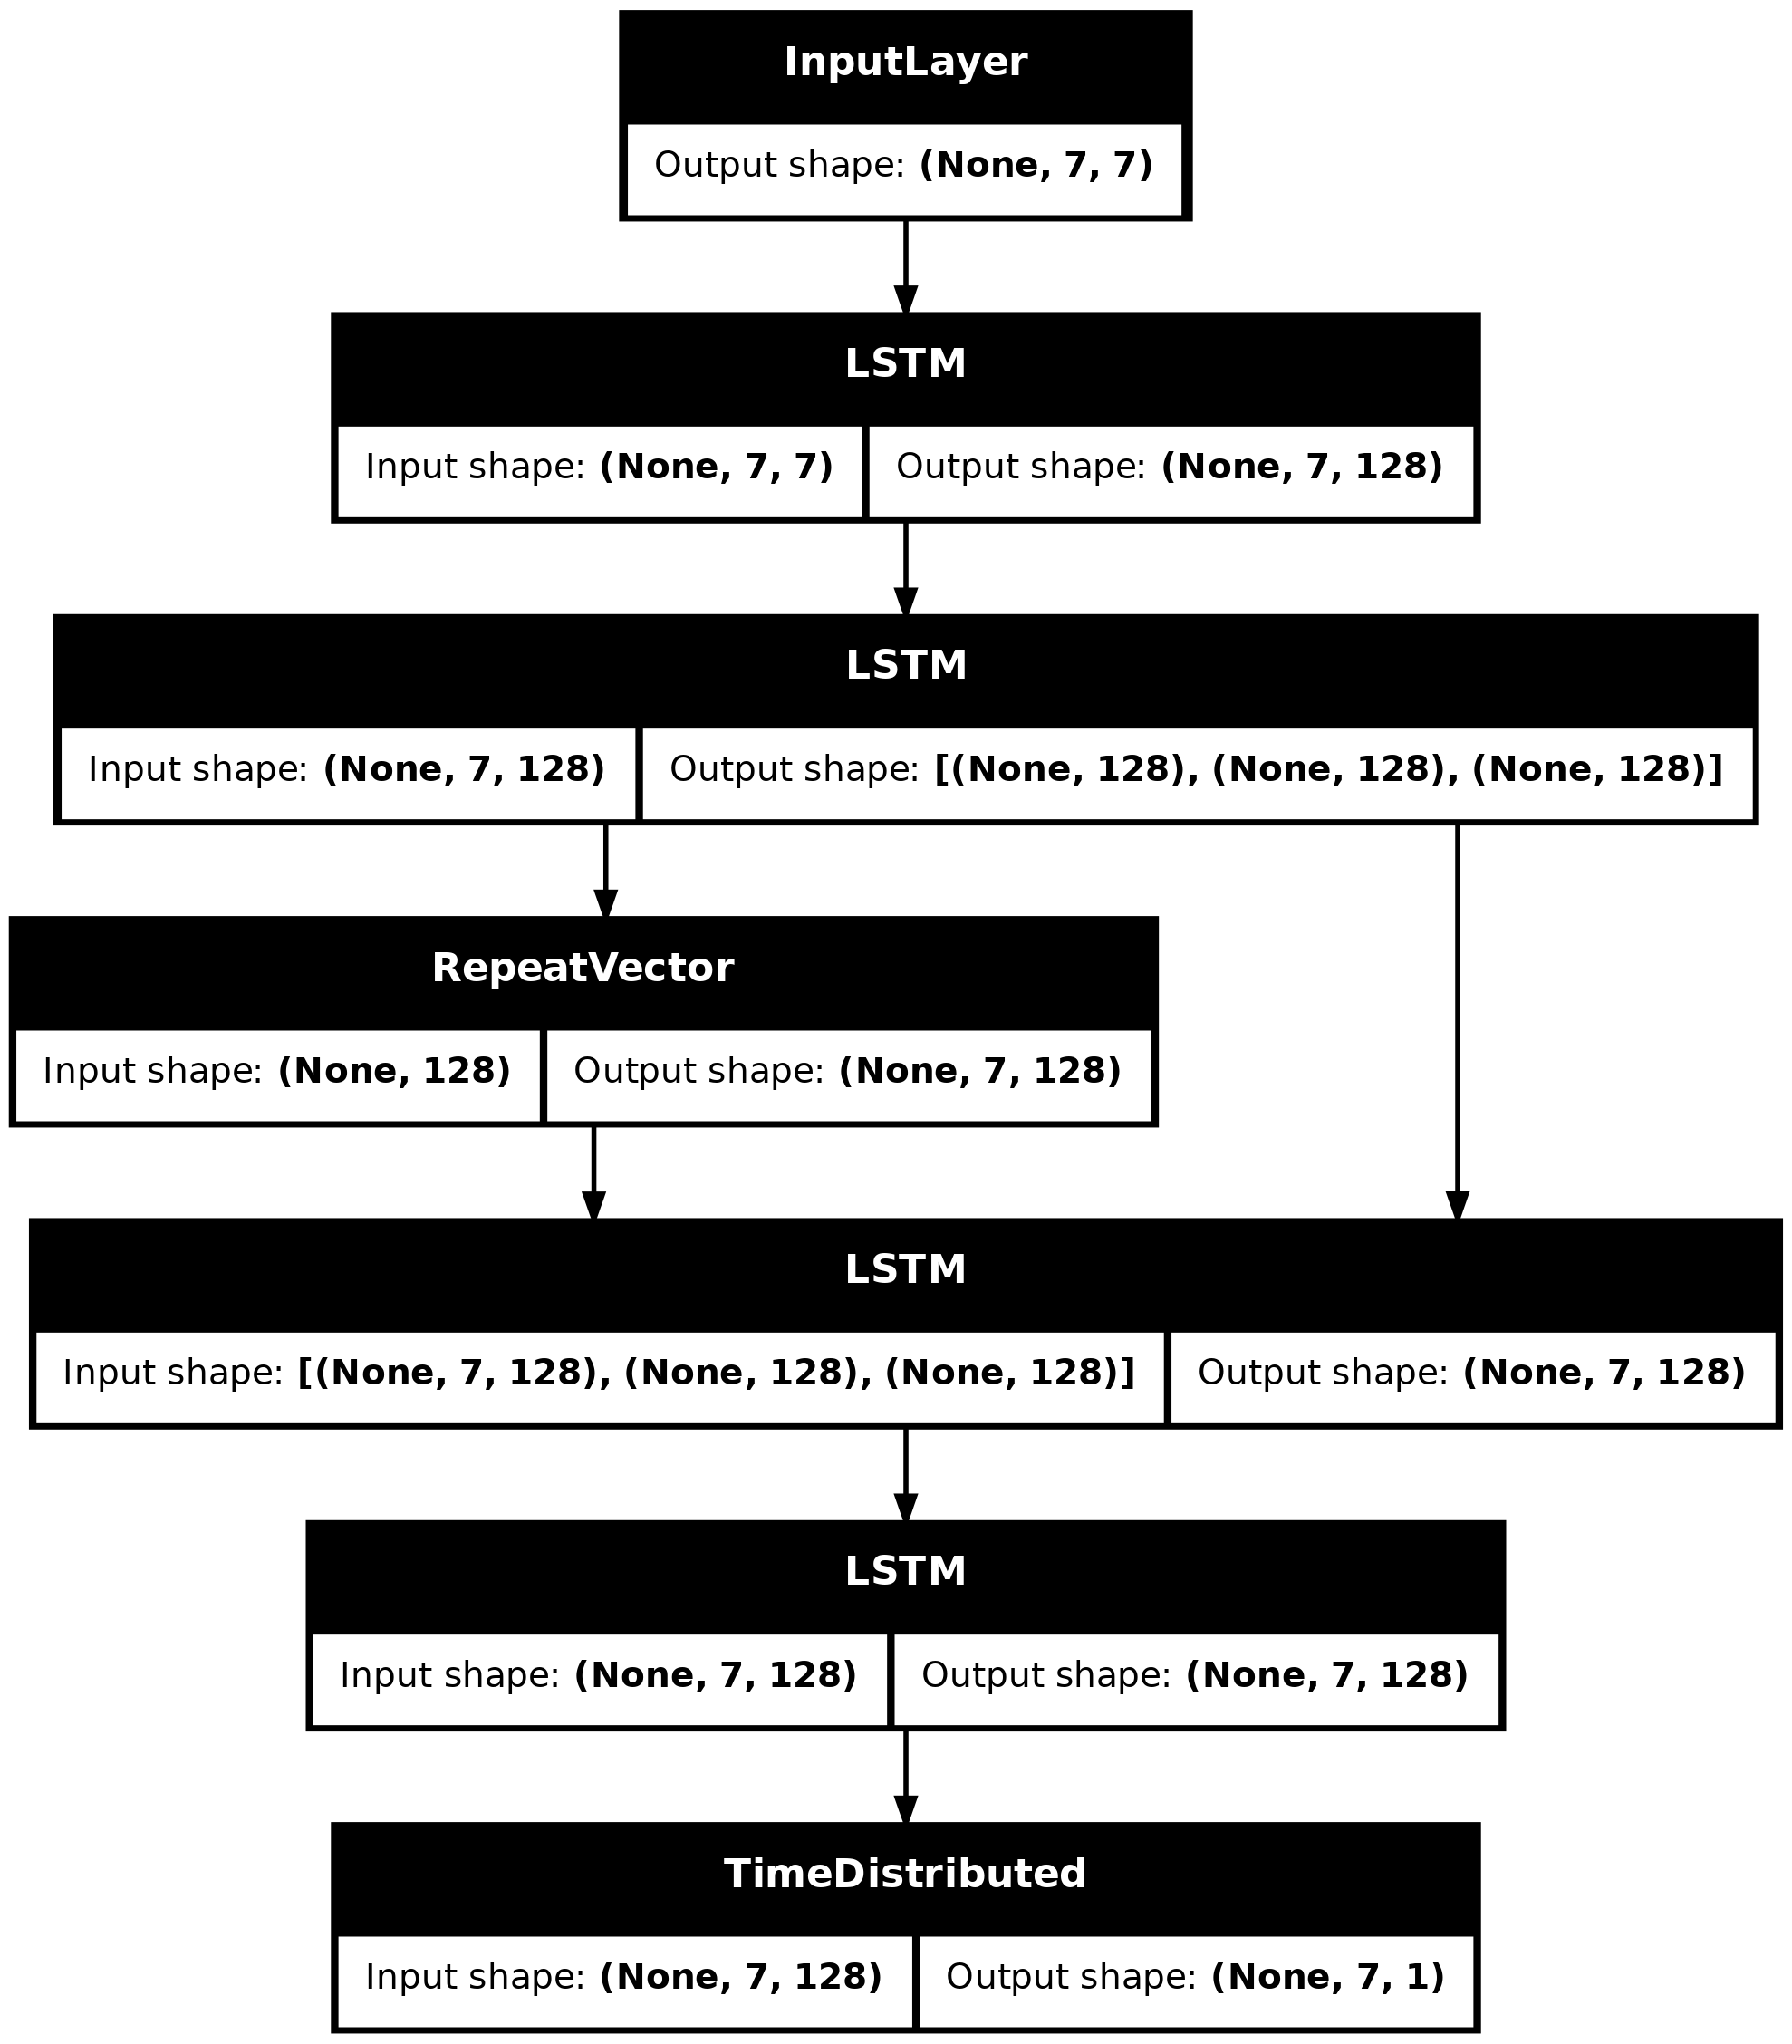

In [2]:
# ⬇ run this in the same env where you trained the model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils  import plot_model

model = load_model("models/best_multivariate_combined_model.keras")  # or best_univariate_model.keras
plot_model(model,
           to_file   = "lstm_encoder_decoder.png",
           show_shapes = True,   # prints (batch, time-steps, features)
           dpi         = 200)    # 300 if you need print-ready


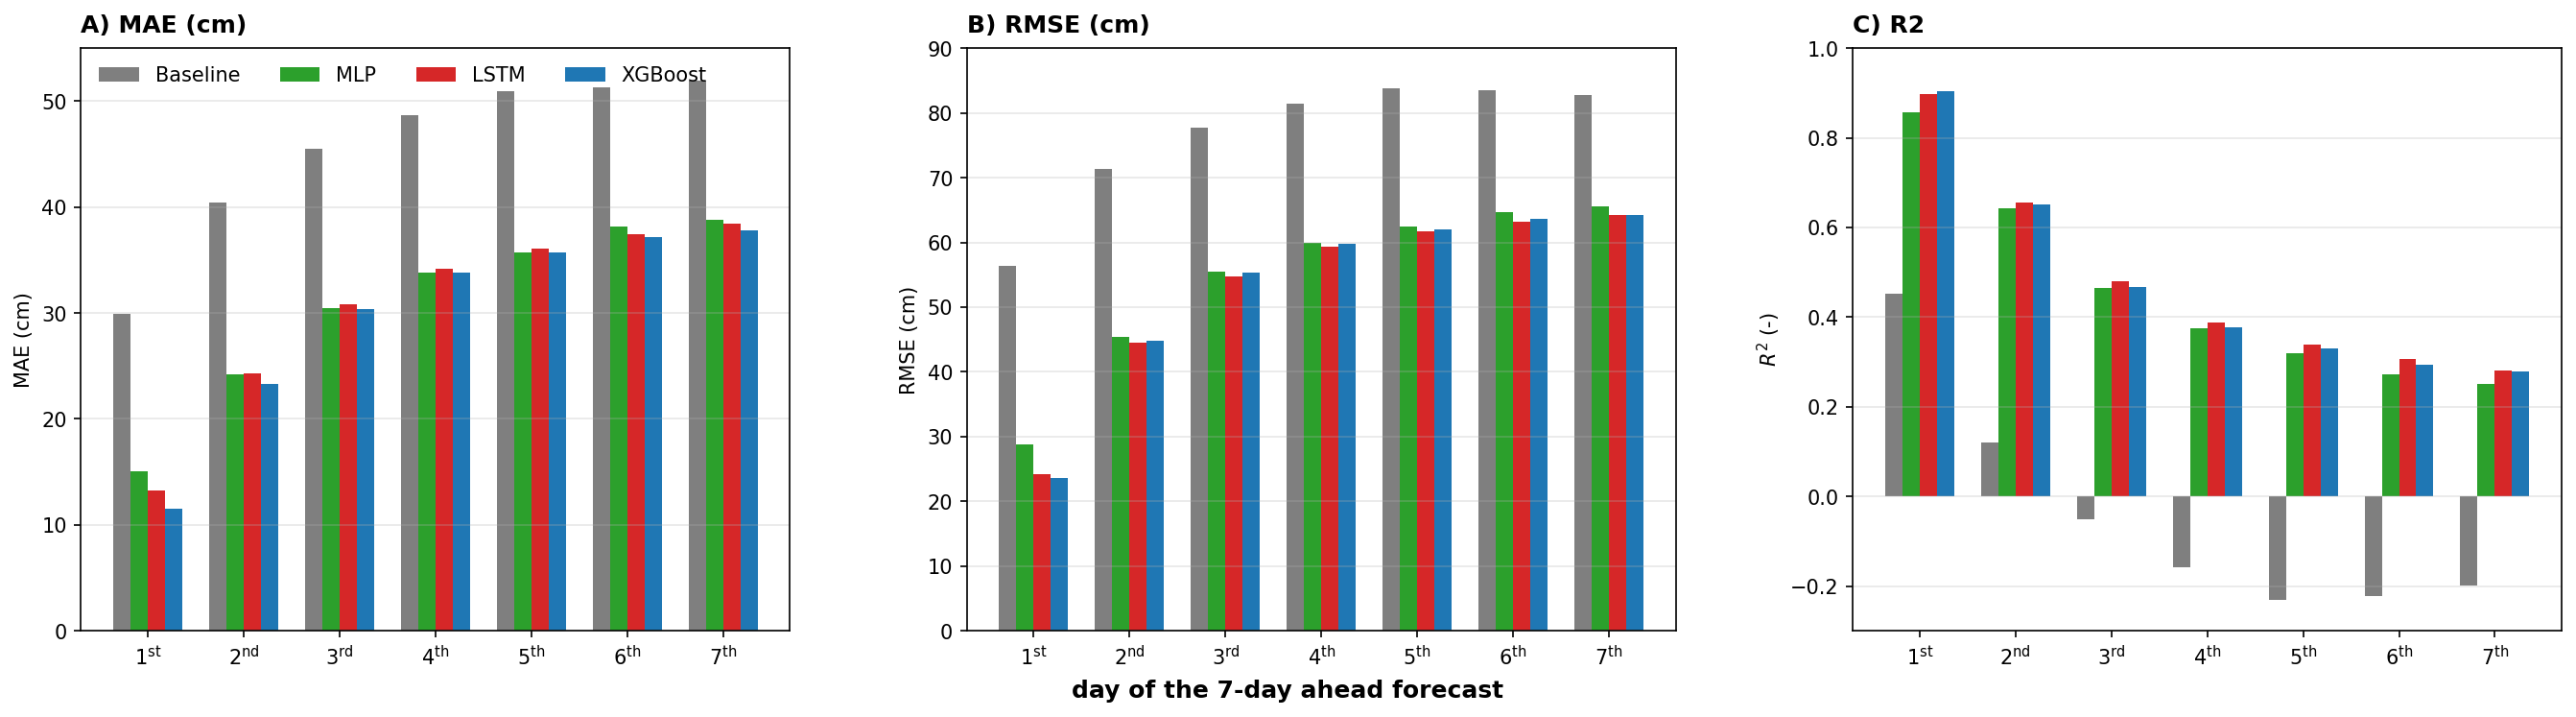

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import string

# ------------------------------------------------------------------
# 1)  FILL-IN: 7-day scores for each model  ↓↓↓
#   • “Baseline” = persistence you just calculated
#   • “LSTM / MLP / XGBoost” = whatever variant you like (multivariate, univariate …)
#
#   Put every value in **metres**.
#
# context7: Fill in actual values from train_baseline_models.ipynb output

metrics_7day = {
    "Baseline": {
        "MAE" : [0.2993, 0.4044, 0.4547, 0.4863, 0.5094, 0.5131, 0.5192],
        "RMSE": [0.5640, 0.7136, 0.7766, 0.8139, 0.8384, 0.8352, 0.8269],
        "R2"  : [0.4527, 0.1198,-0.0508,-0.1583,-0.2309,-0.2219,-0.1999]
    },
    "MLP": {
        "MAE" : [0.1504, 0.2422, 0.3049, 0.3377, 0.3571, 0.3814, 0.3884],
        "RMSE": [0.2873, 0.4543, 0.5549, 0.5991, 0.6250, 0.6465, 0.6550],
        "R2"  : [0.8570, 0.6417, 0.4650, 0.3756, 0.3201, 0.2722, 0.2519]
    },
    "LSTM": {
        "MAE" : [0.1326, 0.2431, 0.3086, 0.3417, 0.3606, 0.3742, 0.3839],
        "RMSE": [0.2424, 0.4457, 0.5467, 0.5930, 0.6165, 0.6312, 0.6426],
        "R2"  : [0.8982, 0.6553, 0.4807, 0.3884, 0.3385, 0.3060, 0.2798]
    },
    "XGBoost": {
        "MAE" : [0.1152, 0.2333, 0.3034, 0.3377, 0.3573, 0.3716, 0.3780],
        "RMSE": [0.2362, 0.4482, 0.5538, 0.5980, 0.6201, 0.6367, 0.6427],
        "R2"  : [0.9033, 0.6514, 0.4671, 0.3780, 0.3307, 0.2940, 0.2797]
    }
}
# ------------------------------------------------------------------

# 2)  SOME COSMETIC SETTINGS
model_colours = {
    "LSTM"    : "#d62728",   # red
    "MLP"     : "#2ca02c",   # green
    "XGBoost" : "#1f77b4",   # blue
    "Baseline": "#7f7f7f"    # grey
}

# Calculate WI (Willmott Index) based on the formula
def calculate_wi(predictions, observations):
    """Calculate Willmott Index"""
    pred = np.array(predictions)
    obs = np.array(observations)
    obs_mean = np.mean(obs)
    
    numerator = np.sum((pred - obs) ** 2)
    denominator = np.sum((np.abs(pred - obs_mean) + np.abs(obs - obs_mean)) ** 2)
    
    wi = 1 - (numerator / denominator) if denominator != 0 else 1
    return wi

metrics_to_plot = ["MAE", "RMSE", "R2"]  # Remove WI
horizons = np.arange(1, 8)                      # 1 … 7

# 3)  BUILD FIGURE GRID (1x3 for three metrics)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=150, sharex=True)

bar_width = 0.18
offsets   = np.linspace(-(len(metrics_7day)-1)/2,
                         (len(metrics_7day)-1)/2,
                         len(metrics_7day)) * bar_width

for panel_idx, (ax, met) in enumerate(zip(axes, metrics_to_plot)):
    # --- loop through models & plot bars ------------------------------------
    for k, (model, off) in enumerate(zip(metrics_7day.keys(), offsets)):
        vals = metrics_7day[model][met]
        if vals is None or np.all(np.isnan(vals)):
            continue
        vals_arr = np.array(vals, dtype=float)
        
        # Convert meters to cm for MAE and RMSE
        if met in ["MAE", "RMSE"]:
            vals_arr = vals_arr * 100  # Convert m to cm
        
        ax.bar(horizons + off, vals_arr, bar_width,
               label=model if panel_idx == 0 else "",   # legend only once
               color=model_colours[model])

    # --- axes cosmetics ------------------------------------------------------
    # Add "(cm)" to MAE/RMSE panel headers for self-contained titles
    if met in ["MAE", "RMSE"]:
        title_text = f"{string.ascii_uppercase[panel_idx]}) {met} (cm)"
    else:
        title_text = f"{string.ascii_uppercase[panel_idx]}) {met}"
    
    ax.set_title(title_text, loc='left', pad=8, fontweight='bold')
    ax.set_xticks(horizons)
    ax.set_xticklabels([f"{d}$^{{\\mathrm{{st}}}}$" if d == 1 else f"{d}$^{{\\mathrm{{nd}}}}$" if d == 2 else f"{d}$^{{\\mathrm{{rd}}}}$" if d == 3 else f"{d}$^{{\\mathrm{{th}}}}$"
                        for d in horizons])
    
    # Set y-axis labels based on metric
    if met == "R2":
        ax.set_ylim(-0.3, 1.0)
        ax.set_ylabel(r"$R^{2}$ (-)")
    else:
        ax.set_ylabel(f"{met} (cm)")
        # Set appropriate y-limits in cm to show all data including baseline
        if met == "RMSE":
            ax.set_ylim(0, 90)  # Increased to show baseline values up to ~83cm
        else:  # MAE
            ax.set_ylim(0, 55)  # Increased to show baseline values up to ~52cm
    
    ax.grid(axis="y", alpha=0.3)

# Add legend
axes[0].legend(frameon=False, ncol=4, loc='upper left')

fig.text(0.5, 0.02, "day of the 7-day ahead forecast", ha="center", fontsize=12, weight="bold")
plt.tight_layout(rect=(0, 0.03, 1, 1))

# Add breathing room between panels
fig.subplots_adjust(wspace=0.25)

# Save high-resolution version for thesis
fig.savefig("fig_model_perf.png", dpi=300, bbox_inches="tight")
plt.show()


Loading dataset and preparing data...
Validation period: 2019-01-01 00:00:00 to 2025-06-01 00:00:00
Validation samples: 2344
Loading scalers and scaling data...
Sequence shapes - X_val_seq: (2331, 7, 7), y_val: (2331, 7)
Flattened shape - X_val_flat: (2331, 49)
Loading models and making predictions...
All predictions completed!
Creating plots for 2331 prediction points...
Date range: 2019-01-08 00:00:00 to 2025-05-26 00:00:00


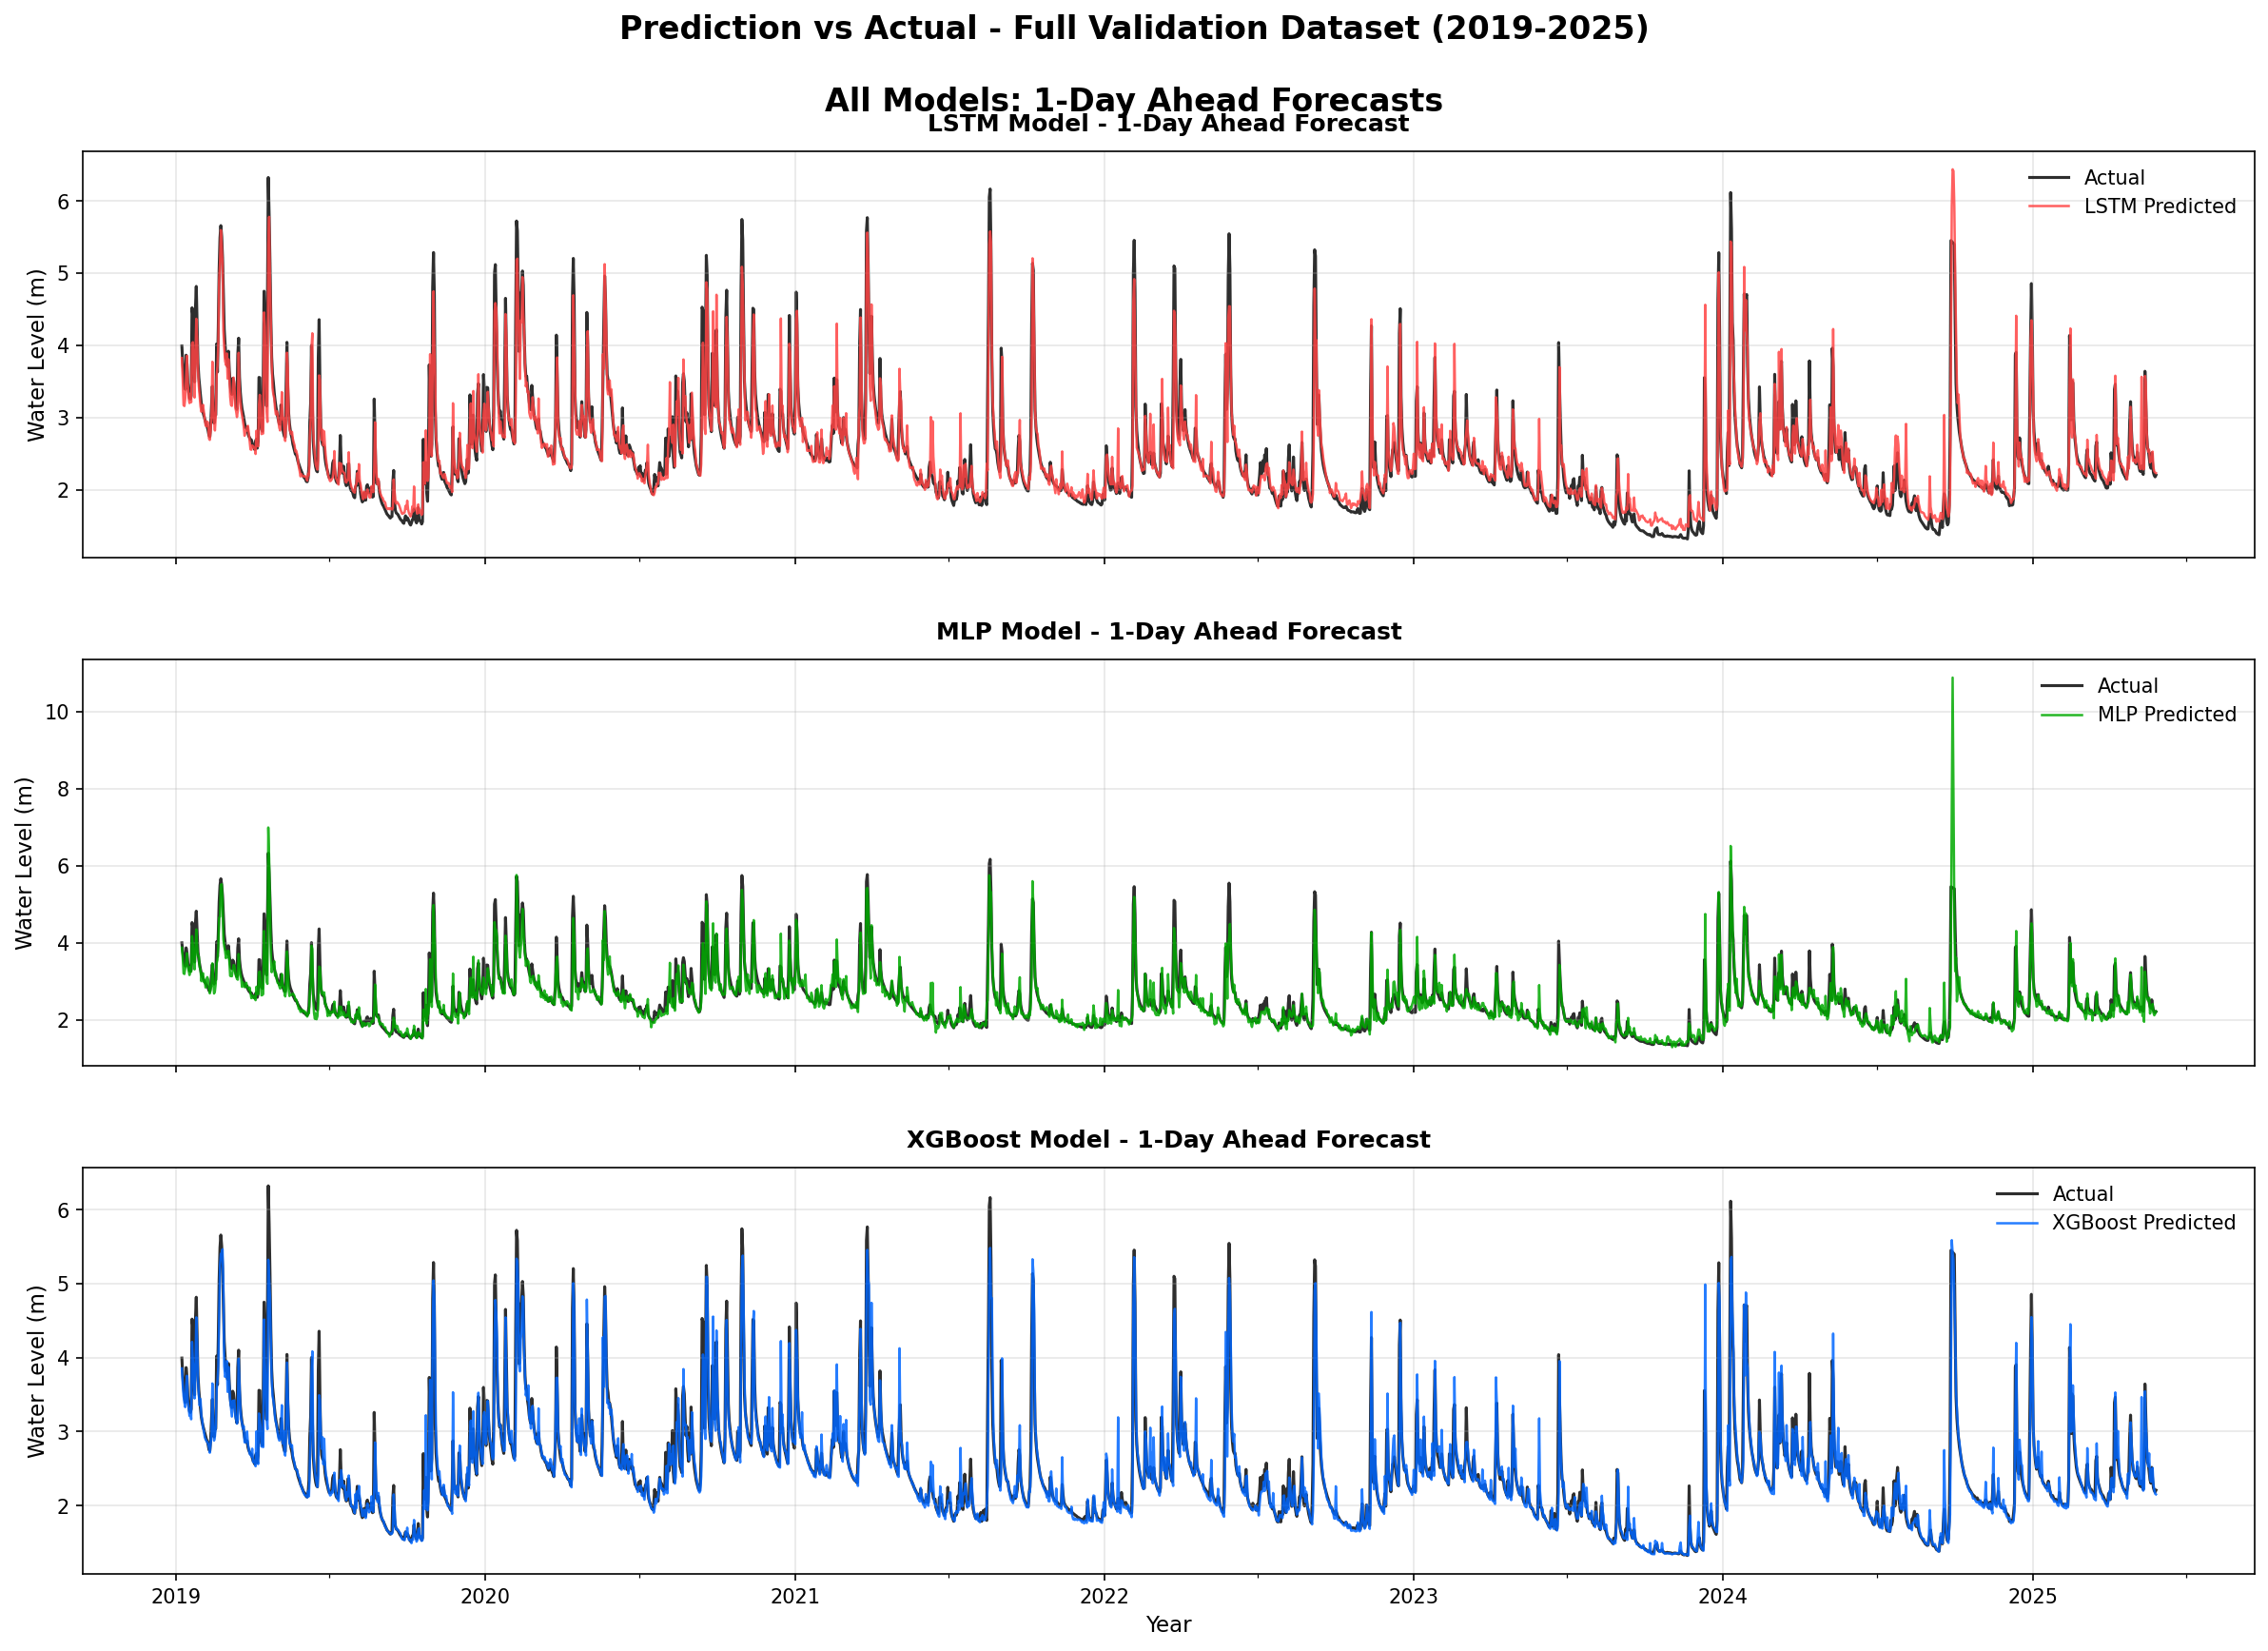

Plot saved as 'prediction_vs_actual_all_models.png'

SUMMARY OF VALIDATION PERFORMANCE (1-DAY AHEAD)
    LSTM -> MAE: 0.1429 m, RMSE: 0.2474 m, R²: 0.8940
     MLP -> MAE: 0.1504 m, RMSE: 0.2873 m, R²: 0.8570
 XGBoost -> MAE: 0.1152 m, RMSE: 0.2362 m, R²: 0.9033


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import xgboost as xgb
from datetime import datetime

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Loading dataset and preparing data...")
# 1. Load and prepare data (same as training)
df_multi = pd.read_csv('data/combined_dataset.csv', index_col='datetime', parse_dates=True)
df_multi = df_multi[['stage_m'] + [col for col in df_multi.columns if col != 'stage_m']]

# 2. Split data using same dates as training
split_date_train_end = '2018-04-21'
split_date_val_start = '2019-01-01'
train_data = df_multi.loc[df_multi.index < split_date_train_end]
val_data = df_multi.loc[df_multi.index >= split_date_val_start]

print(f"Validation period: {val_data.index.min()} to {val_data.index.max()}")
print(f"Validation samples: {len(val_data)}")

# 3. Load scalers and scale data
print("Loading scalers and scaling data...")
scaler_combined = joblib.load('models/multivariate_combined_scaler.joblib')  # For LSTM
scaled_train_data = scaler_combined.transform(train_data)
scaled_val_data = scaler_combined.transform(val_data)

# 4. Create sequences
N_PAST = 7
N_FUTURE = 7
n_features = scaled_train_data.shape[1]

def create_sequences(data, n_past, n_future):
    X, y = [], []
    target_col_index = 0
    for i in range(n_past, len(data) - n_future + 1):
        X.append(data[i - n_past:i, :])
        y.append(data[i:i + n_future, target_col_index])
    return np.array(X), np.array(y)

X_val_seq, y_val = create_sequences(scaled_val_data, N_PAST, N_FUTURE)
X_val_flat = X_val_seq.reshape(X_val_seq.shape[0], -1)  # For MLP and XGBoost

print(f"Sequence shapes - X_val_seq: {X_val_seq.shape}, y_val: {y_val.shape}")
print(f"Flattened shape - X_val_flat: {X_val_flat.shape}")

# 5. Load models and make predictions
print("Loading models and making predictions...")

# Load LSTM model
lstm_model = load_model('models/best_multivariate_combined_model.keras')
lstm_predictions_scaled = lstm_model.predict(X_val_seq, verbose=0).squeeze()

# Load MLP model  
mlp_model = load_model('models/best_baseline_mlp_model.keras')
mlp_predictions_scaled = mlp_model.predict(X_val_flat, verbose=0)

# Load XGBoost model
xgb_model = joblib.load('models/best_baseline_xgboost_model.joblib')
xgb_predictions_scaled = xgb_model.predict(X_val_flat)

print("All predictions completed!")

# 6. Inverse scale predictions and true values
def inverse_scale_predictions(predictions_scaled, y_true_scaled, scaler, n_features):
    """Helper function to inverse scale predictions and true values"""
    # Create dummy arrays for inverse scaling
    dummy_preds = np.zeros((len(predictions_scaled.flatten()), n_features))
    dummy_preds[:, 0] = predictions_scaled.flatten()
    predictions_original = scaler.inverse_transform(dummy_preds)[:, 0].reshape(y_true_scaled.shape)
    
    dummy_true = np.zeros((len(y_true_scaled.flatten()), n_features))
    dummy_true[:, 0] = y_true_scaled.flatten()
    y_true_original = scaler.inverse_transform(dummy_true)[:, 0].reshape(y_true_scaled.shape)
    
    return predictions_original, y_true_original

# Inverse scale all predictions
lstm_preds_orig, y_true_orig = inverse_scale_predictions(lstm_predictions_scaled, y_val, scaler_combined, n_features)
mlp_preds_orig, _ = inverse_scale_predictions(mlp_predictions_scaled, y_val, scaler_combined, n_features) 
xgb_preds_orig, _ = inverse_scale_predictions(xgb_predictions_scaled, y_val, scaler_combined, n_features)

# 7. Create date index for validation predictions
val_dates = val_data.index[N_PAST:len(y_true_orig) + N_PAST]

print(f"Creating plots for {len(val_dates)} prediction points...")
print(f"Date range: {val_dates.min()} to {val_dates.max()}")

# 8. Create prediction vs actual plots for each model
models_data = {
    'LSTM': {'predictions': lstm_preds_orig, 'color': '#FF4444', 'linestyle': '-'},
    'MLP': {'predictions': mlp_preds_orig, 'color': '#00AA00', 'linestyle': '-'}, 
    'XGBoost': {'predictions': xgb_preds_orig, 'color': '#0066FF', 'linestyle': '-'}
}

# Create subplots for each model
fig, axes = plt.subplots(3, 1, figsize=(16, 12), dpi=150)
fig.suptitle('Prediction vs Actual - Full Validation Dataset (2019-2025)\nAll Models: 1-Day Ahead Forecasts\n', 
             fontsize=16, fontweight='bold', y=0.96)

for idx, (model_name, model_data) in enumerate(models_data.items()):
    ax = axes[idx]
    
    # Plot actual values (same for all models) - using a darker, thicker line
    ax.plot(val_dates, y_true_orig[:, 0], label='Actual', color='#2E2E2E', 
            linewidth=1.5, alpha=1.0, zorder=1)
    
    # Plot model predictions (1-day ahead) - using brighter, contrasting colors
    ax.plot(val_dates, model_data['predictions'][:, 0], 
           label=f'{model_name} Predicted', color=model_data['color'], 
           linewidth=1.2, alpha=0.85, linestyle=model_data['linestyle'], zorder=2)
    
    # Formatting
    ax.set_title(f'{model_name} Model - 1-Day Ahead Forecast', fontsize=12, fontweight='bold', pad=10)
    ax.set_ylabel('Water Level (m)', fontsize=11)
    ax.legend(frameon=False, loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Format x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator([1, 7]))
    
    # Add some spacing between subplots
    if idx < 2:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Year', fontsize=11)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')

plt.tight_layout()
plt.subplots_adjust(top=0.88, hspace=0.25)
plt.show()

# Save the plot
fig.savefig("prediction_vs_actual_all_models.png", dpi=300, bbox_inches="tight")
print("Plot saved as 'prediction_vs_actual_all_models.png'")

print("\n" + "="*70)
print("SUMMARY OF VALIDATION PERFORMANCE (1-DAY AHEAD)")
print("="*70)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for model_name, model_data in models_data.items():
    preds_1day = model_data['predictions'][:, 0]  # 1-day ahead predictions
    actual_1day = y_true_orig[:, 0]
    
    mae = mean_absolute_error(actual_1day, preds_1day)
    rmse = np.sqrt(mean_squared_error(actual_1day, preds_1day))
    r2 = r2_score(actual_1day, preds_1day)
    
    print(f"{model_name:>8} -> MAE: {mae:.4f} m, RMSE: {rmse:.4f} m, R²: {r2:.4f}")

print("="*70)
